<a href="https://colab.research.google.com/github/s-c-soma/Deeplearning-CMPE-258/blob/main/Assignment_6/Assignment_6b_1_CNN_based_Image_Classifier_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN based image classifier Using Keras



## Implementation Details and Discussion

* This colab implements the CNN based clsssifier using Keras.

* Here I have followed the steps following reference colab provided by Professor:
> 1. I have used two different datasets. One is custom- Cats-Dog image dataset and the Fashion MNIST dataset
> 2. Some preprocessing such as augmentation and standardization on datasets
> 3. Then I have build the networt to build CNN based classifier
> 4. Then I have trained the classifier model 
> 5. Finally I have done some prediction
> 6. At the last I have done some unit testing on autograd as well




# Check if GPU/TPU available

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat May  1 05:35:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# import libraries

In [1]:
# load some default Python modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist
from sklearn.metrics import mean_squared_error
import itertools
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import fashion_mnist
from sklearn.metrics import mean_squared_error
import itertools
import math
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D
from tensorflow import keras

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
% matplotlib inline

plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

# Load Data - Cats and Dog

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   134M      0  0:00:05  0:00:05 --:--:--  136M


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [4]:
!ls PetImages

Cat  Dog


In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


# Load Data- F-MNIST



In [6]:
# Read in the Mnist dataset
fashion_mnist = fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4423680/4422102 [==============================] - 0s 0us/step

train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


# Visualize the dataset

In [7]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


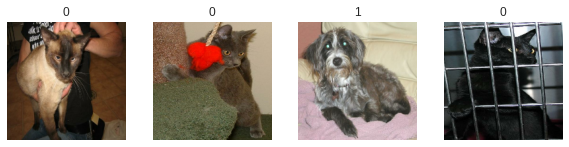

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

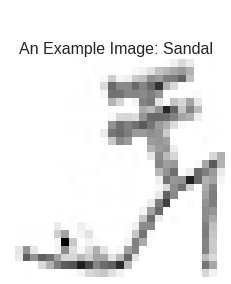

In [10]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

# Preprocessing

## Data Augmentation

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

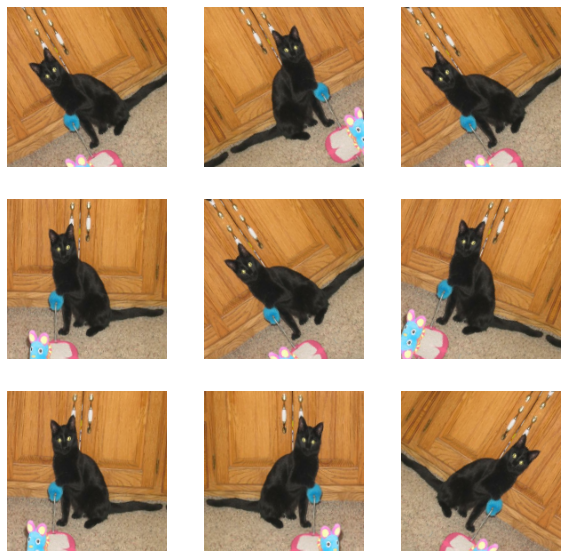

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [15]:
# Set hyper params for image augmentation
featurewise_center=False 
samplewise_center=False 
featurewise_std_normalization=False 
samplewise_std_normalization=False 
zca_whitening=False 
rotation_range=10 
zoom_range = 0.1 
width_shift_range=0.1 
height_shift_range=0.1 
horizontal_flip=True 
vertical_flip=True

In [16]:
# Configure Image Data Generator
gen = ImageDataGenerator(
        featurewise_center = featurewise_center,
        samplewise_center = samplewise_center, 
        featurewise_std_normalization = featurewise_std_normalization,
        samplewise_std_normalization = samplewise_std_normalization, 
        zca_whitening = zca_whitening, 
        rotation_range = rotation_range,
        zoom_range = zoom_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip)

## Standardize Image Dataset

In [17]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

# Train- Testing Split

In [18]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Network Build 

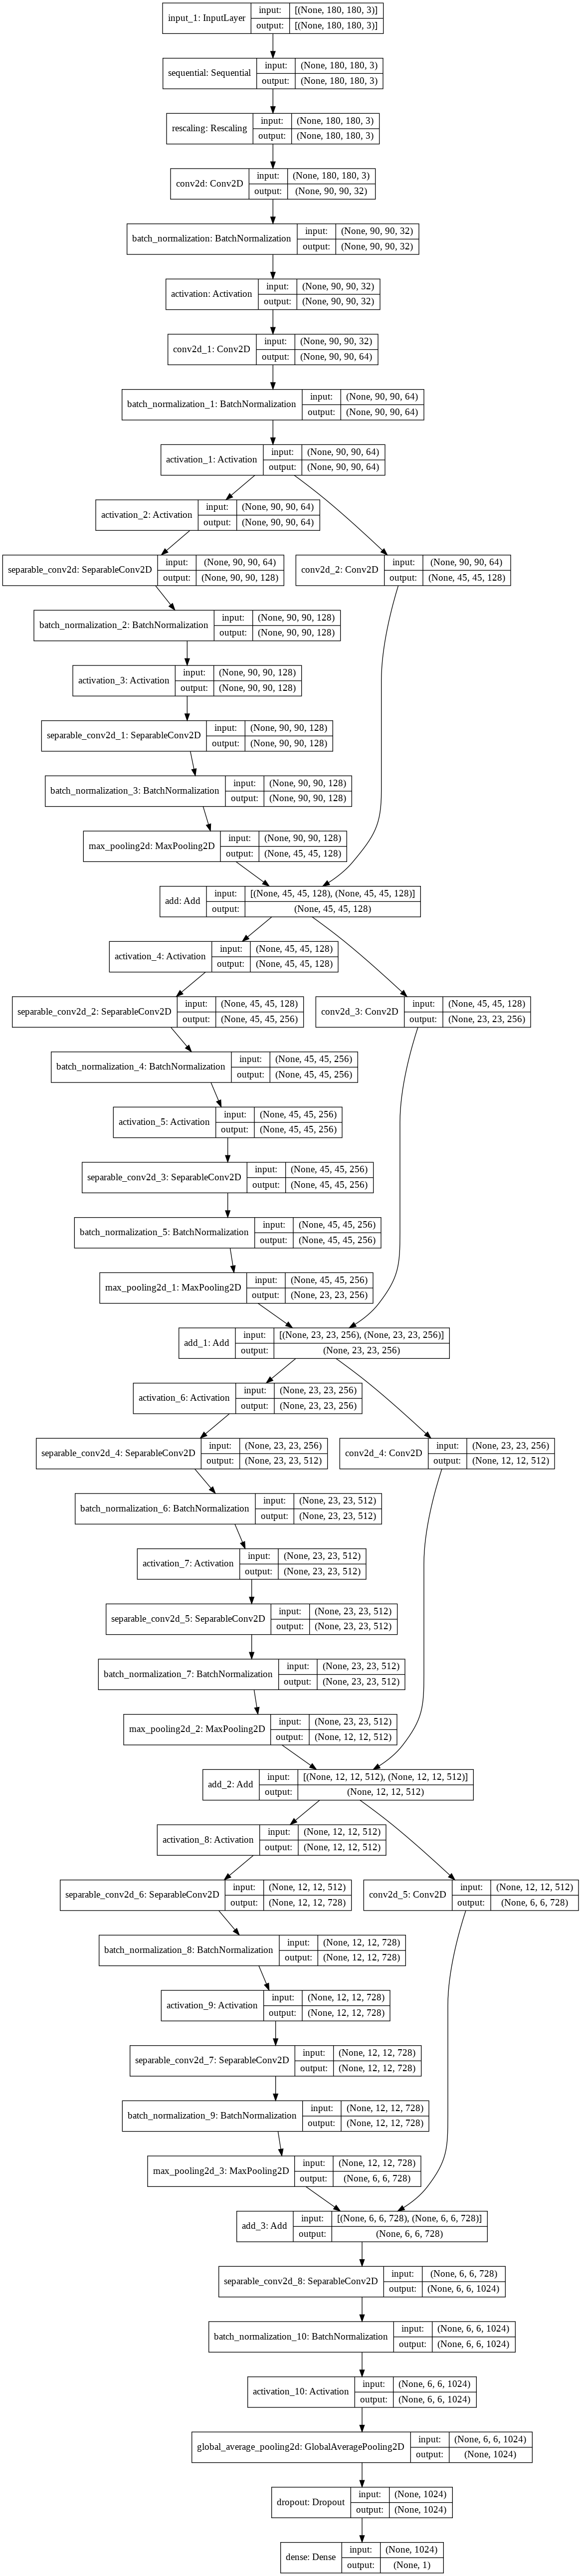

In [19]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.MaxPooling2D(3, strides=2, padding="same"),
  keras.layers.Flatten(),
  keras.layers.Dense(10, name='Dense')
])

model.summary()
model.compile(optimizer='rmsprop', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])


In [ ]:
num_epochs = 5
batch_size = 32
patience = 10
verbose = 1
factor = 0.2
min_lr = 0.001
monitor = 'val_loss'

# Set adaptive learing rate setting
adaptive_lr = ReduceLROnPlateau(monitor=monitor, 
                                patience=patience, 
                                verbose=verbose, 
                                factor=factor, 
                                min_lr=min_lr)

# Model Fit and Prediction

In [ ]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
586/586 [==============================] - 82s 137ms/step - loss: 0.2646 - accuracy: 0.8884 - val_loss: 0.4498 - val_accuracy: 0.7962
Epoch 2/5
585/586 [============================>.] - ETA: 0s - loss: 0.2297 - accuracy: 0.9032

In [ ]:
# fit predict
history = model.fit(gen.flow(train_images, train_labels, batch_size=batch_size), 
                    steps_per_epoch=math.floor(train_images.shape[0] / batch_size), 
                    epochs=num_epochs, callbacks=[adaptive_lr, tensorboard_callback], 
                    validation_data=(test_images, test_labels))

# Prediction Using Cats/Dog and F-MNIST

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

In [ ]:
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

In [ ]:
# Plot the loss
plt.plot(history.history["loss"], 'b', label="training loss")
plt.plot(history.history["val_loss"], 'r', label="validation loss")
plt.legend(loc="best")
plt.show()